In [97]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import os
import shutil


In [98]:
# Load all CSV files
fpt_df = pd.read_csv('D:\\Github anyud\\final\\Data_stock\\FPT Historical Data.csv')
googl_df = pd.read_csv('D:\\Github anyud\\final\\Data_stock\\GOOGL Historical Data.csv')
aapl_df = pd.read_csv('D:\\Github anyud\\final\\Data_stock\\AAPL Historical Data.csv')
acb_df = pd.read_csv('D:\\Github anyud\\final\\Data_stock\\ACB Historical Data.csv')
bid_df = pd.read_csv('D:\\Github anyud\\final\\Data_stock\\BID Historical Data.csv')

# Function to calculate the required columns for each dataset
def process_data(df):
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])  # Drop rows where 'Date' is not valid
    df = df.sort_values('Date')  # Sort by date in ascending order

    df['Price'] = df['Price'].apply(lambda x: float(str(x).replace(',', '')))  # Convert 'Price' to numeric
    
    # Calculate 'price after diff'
    df['Price After Diff'] = df['Price'].diff()

    # Calculate moving averages
    df['MA30 Before Diff'] = df['Price'].rolling(window=30).mean()
    df['MA90 Before Diff'] = df['Price'].rolling(window=90).mean()

    return df[['Date', 'Price', 'Price After Diff', 'MA30 Before Diff', 'MA90 Before Diff']]

# Process all datasets
fpt_processed = process_data(fpt_df)
googl_processed = process_data(googl_df)
aapl_processed = process_data(aapl_df)
acb_processed = process_data(acb_df)
bid_processed = process_data(bid_df)

# Save the processed data to new CSV files
fpt_processed.to_csv('D:\\Github anyud\\final\\Data_stock\\FPT_Processed.csv', index=False)
googl_processed.to_csv('D:\\Github anyud\\final\\Data_stock\\GOOGL_Processed.csv', index=False)
aapl_processed.to_csv('D:\\Github anyud\\final\\Data_stock\\AAPL_Processed.csv', index=False)
acb_processed.to_csv('D:\\Github anyud\\final\\Data_stock\\ACB_Processed.csv', index=False)
bid_processed.to_csv('D:\\Github anyud\\final\\Data_stock\\BID_Processed.csv', index=False)

# Return the paths of the new files
['D:\\Github anyud\\final\\Data_stock\\FPT_Processed.csv', 'D:\\Github anyud\\final\\Data_stock\\GOOGL_Processed.csv', 'D:\\Github anyud\\final\\Data_stock\\AAPL_Processed.csv', 'D:\\Github anyud\\final\\Data_stock\\ACB_Processed.csv', 'D:\\Github anyud\\final\\Data_stock\\BID_Processed.csv']

['D:\\Github anyud\\final\\Data_stock\\FPT_Processed.csv',
 'D:\\Github anyud\\final\\Data_stock\\GOOGL_Processed.csv',
 'D:\\Github anyud\\final\\Data_stock\\AAPL_Processed.csv',
 'D:\\Github anyud\\final\\Data_stock\\ACB_Processed.csv',
 'D:\\Github anyud\\final\\Data_stock\\BID_Processed.csv']

In [99]:
acb_data = pd.read_csv("D:\\Github anyud\\final\\Data_stock\\ACB_Processed.csv")
aapl_data = pd.read_csv('D:\\Github anyud\\final\\Data_stock\\ACB_Processed.csv')
bid_data = pd.read_csv('D:\\Github anyud\\final\\Data_stock\\BID_Processed.csv')
fpt_data = pd.read_csv('D:\\Github anyud\\final\\Data_stock\\FPT_Processed.csv')
googl_data = pd.read_csv('D:\\Github anyud\\final\\Data_stock\\GOOGL_Processed.csv')

In [100]:
print(acb_data.shape)
print(aapl_data.shape)
print(bid_data.shape)
print(fpt_data.shape)
print(googl_data.shape)

(2431, 5)
(2431, 5)
(2418, 5)
(2418, 5)
(2440, 5)


In [101]:
# Split data into training and test sets (80% training, 20% test)
def split_data(df):
    train_size = int(len(df) * 0.8)
    train_set = df.iloc[:train_size].copy()
    test_set = df.iloc[train_size:].copy()
    return train_set, test_set

def normalize_selected_columns(train, test, columns):
    scaler = MinMaxScaler()
    
    # Apply normalization to the selected columns, including 'Price'
    train_scaled = train.copy()
    test_scaled = test.copy()
    
    train_scaled[columns] = scaler.fit_transform(train[columns])
    test_scaled[columns] = scaler.transform(test[columns])
    
    return train_scaled, test_scaled, scaler

# Sequence generation for 'Price' only, keeping the other features unchanged
def create_sequences(full_data, time_step=60):
    X, y = [], []
    
    # Create sequences for the last 60 time steps
    for i in range(time_step, len(full_data)):
        # Sequence of the last 60 time steps for all features (including Price and others)
        feature_sequence = full_data.iloc[i - time_step:i].values
        
        # Append the full sequence of shape (60, 4)
        X.append(feature_sequence)
        
        # 'y' will be the current 'Price' value
        y.append(full_data.iloc[i]['Price'])  # Current Price value as label
    
    # Convert labels to a 2D array with shape (n_samples, 1)
    return np.array(X), np.array(y).reshape(-1, 1)

In [102]:
from sklearn.preprocessing import MinMaxScaler


# 2. Split the data
aapl_train, aapl_test = split_data(aapl_data)


# 3. Define the columns to normalize (excluding 'Price After Diff')
columns_to_normalize = ['Price', 'MA30 Before Diff', 'MA90 Before Diff']

# 4. Normalize the data (including the 'Price' column)
aapl_train_normalized, aapl_test_normalized, scaler = normalize_selected_columns(aapl_train, aapl_test, columns_to_normalize)

# 5. Select normalized columns for sequence generation (without 'Price After Diff')
aapl_train_full = aapl_train_normalized[columns_to_normalize]
aapl_test_full = aapl_test_normalized[columns_to_normalize]


# 6. Create sequences for the training and test sets
aapl_train_sequences, aapl_train_labels = create_sequences(aapl_train_full, time_step=60)
aapl_test_sequences, aapl_test_labels = create_sequences(aapl_test_full, time_step=60)


In [103]:
print(aapl_train.columns)
print(aapl_test.columns)


Index(['Date', 'Price', 'Price After Diff', 'MA30 Before Diff',
       'MA90 Before Diff'],
      dtype='object')
Index(['Date', 'Price', 'Price After Diff', 'MA30 Before Diff',
       'MA90 Before Diff'],
      dtype='object')


In [104]:
# 7. Print the shape of the resulting sequences and labels
print("Shape of training sequences:", aapl_train_sequences.shape)  # Expected: (num_samples, 60, num_features)
print("Shape of training labels:", aapl_train_labels.shape)        # Expected: (num_samples, 1)
print("Shape of test sequences:", aapl_test_sequences.shape)       # Expected: (num_samples, 60, num_features)
print("Shape of test labels:", aapl_test_labels.shape)             # Expected: (num_samples, 1)

Shape of training sequences: (1884, 60, 3)
Shape of training labels: (1884, 1)
Shape of test sequences: (427, 60, 3)
Shape of test labels: (427, 1)


In [105]:
# Forward fill NaN values in the sequences
aapl_train_sequences = np.where(np.isnan(aapl_train_sequences), 
                                np.nanmean(aapl_train_sequences, axis=0), 
                                aapl_train_sequences)

# Verify if NaNs are resolved
print(np.isnan(aapl_train_sequences).sum())  # Should output 0


0


In [106]:
# Find indices of sequences that contain NaNs
nan_mask = np.any(np.isnan(aapl_train_sequences), axis=(1, 2))

# Remove sequences with NaN values
aapl_train_sequences_cleaned = aapl_train_sequences[~nan_mask]
aapl_train_labels_cleaned = aapl_train_labels[~nan_mask]

# Convert to a DataFrame for better readability
import pandas as pd
aapl_train_sequences_cleaned_df = pd.DataFrame(aapl_train_sequences_cleaned.reshape(-1, aapl_train_sequences_cleaned.shape[2]))

# Display the first few rows of the cleaned sequence data
print(aapl_train_sequences_cleaned_df.head())


          0         1         2
0  0.016984  0.259688  0.290842
1  0.023112  0.259548  0.290687
2  0.020854  0.259408  0.290531
3  0.018275  0.259269  0.290375
4  0.018919  0.259129  0.290220


In [107]:
import numpy as np

# Find the indices where NaNs are located in the sequences
nan_indices = np.argwhere(np.isnan(aapl_train_sequences))

# Display the first 10 NaN locations for inspection
print(nan_indices[:10])

# Optionally, you can also check the actual values at these indices
for index in nan_indices[:10]:
    print(f"NaN found at sequence index: {index[0]}, time step: {index[1]}, feature: {index[2]}")


[]


In [108]:
# # Fill NaN values with the mean of each feature across the sequences
aapl_train_sequences = np.where(np.isnan(aapl_train_sequences), 
                                np.nanmean(aapl_train_sequences, axis=0), 
                                aapl_train_sequences)

# Verify if there are any remaining NaN values
print(np.isnan(aapl_train_sequences).sum())  # Should output 0 after filling
 # Check for NaNs in sequences
print(np.isnan(aapl_train_labels).sum())     # Check for NaNs in labels


0
0


In [109]:
import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout  # Ensure Dropout is imported
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# HyperModel class to search for the best LSTM architecture
class LSTMHyperModel(kt.HyperModel):
    def build(self, hp):
        model = Sequential()
        
        # Define the number of LSTM layers (1 to 3 layers)
        for i in range(hp.Int('num_layers', 1, 3)):
            model.add(LSTM(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32), 
                           return_sequences=(i != hp.Int('num_layers', 1, 3) - 1),  # Only last LSTM doesn't return sequences
                           input_shape=(time_steps, num_features)))
            model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))  # Dropout regularization

        # Output layer for regression (predicting 1 value, the price)
        model.add(Dense(1))

        # Compile the model
        model.compile(optimizer=Adam(
                        hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)),
                      loss='mean_squared_error')

        return model

# Define time steps and number of features based on your sequence data
time_steps = 60  # For example, you have 60 time steps
num_features = 3  # Number of features ('Price', 'Price After Diff', 'MA30 Before Diff', 'MA90 Before Diff')

# Instantiate the hypermodel
hypermodel = LSTMHyperModel()

# Set up the Keras Tuner (using RandomSearch or Hyperband)
tuner = kt.RandomSearch(
    hypermodel,
    objective='val_loss',  # Minimize validation loss
    max_trials=10,         # Number of hyperparameter combinations to try
    executions_per_trial=1, # How many models to train per trial for more robustness
    directory='tuning_dir', # Where to save tuning results
    project_name='acb_tuning' # Name of the tuning project
)

# Print a summary of the search space
tuner.search_space_summary()

# Start the hyperparameter search
tuner.search(aapl_train_sequences_cleaned, aapl_train_labels_cleaned, 
             epochs=20, 
             batch_size=32, 
             validation_split=0.2)

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Print a summary of the best model
best_model.summary()

# Evaluate the best model on the test set
test_loss = best_model.evaluate(aapl_test_sequences, aapl_test_labels)
print(f"Test loss of the best model: {test_loss}")


Reloading Tuner from tuning_dir\acb_tuning\tuner0.json
Search space summary
Default search space size: 8
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_0 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_2 (Float)
{'default': 0.1, 'cond

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 96)             │        38,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,497 (150.38 KB)

 Trainable params: 38,497 (150.38 KB)

 Non-trainable params: 0 (0.00 B)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3383e-06 
Test loss of the best model: 1.404483668920875e-06


In [110]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 1. Predict using the best model
predictions_scaled = best_model.predict(aapl_test_sequences)

# 2. Inverse transform the predictions and actual values (to get them back to the original scale)
# Only the 'Price' column needs to be inverse transformed, so we select the correct part of the scaler
predictions = scaler.inverse_transform(np.concatenate([predictions_scaled, np.zeros((predictions_scaled.shape[0], 2))], axis=1))[:, 0]
actuals = scaler.inverse_transform(np.concatenate([aapl_test_labels, np.zeros((aapl_test_labels.shape[0], 2))], axis=1))[:, 0]

# 3. Calculate RMSE
rmse = np.sqrt(mean_squared_error(actuals, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# 4. Calculate MSE
r_squared = r2_score(actuals, predictions)
print(f"R-squared (R²): {r_squared}")

# 5. Optional: Calculate a proxy for accuracy (within 5% tolerance)
tolerance = 0.05 * actuals  # 5% of actual values
accuracy = np.mean(np.abs(predictions - actuals) < tolerance)
print(f"Accuracy (within 5% tolerance): {accuracy * 100:.2f}%")

# 6. Calculate R-squared (R²)
mse = mean_squared_error(actuals, predictions)
print(f"Mean Squared Error (MSE): {mse}")

# 7. Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")



14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Root Mean Squared Error (RMSE): 2.124426698249913
R-squared (R²): 0.1027424732318597
Accuracy (within 5% tolerance): 0.47%
Mean Squared Error (MSE): 4.513188796237028
Mean Absolute Percentage Error (MAPE): 27.27%


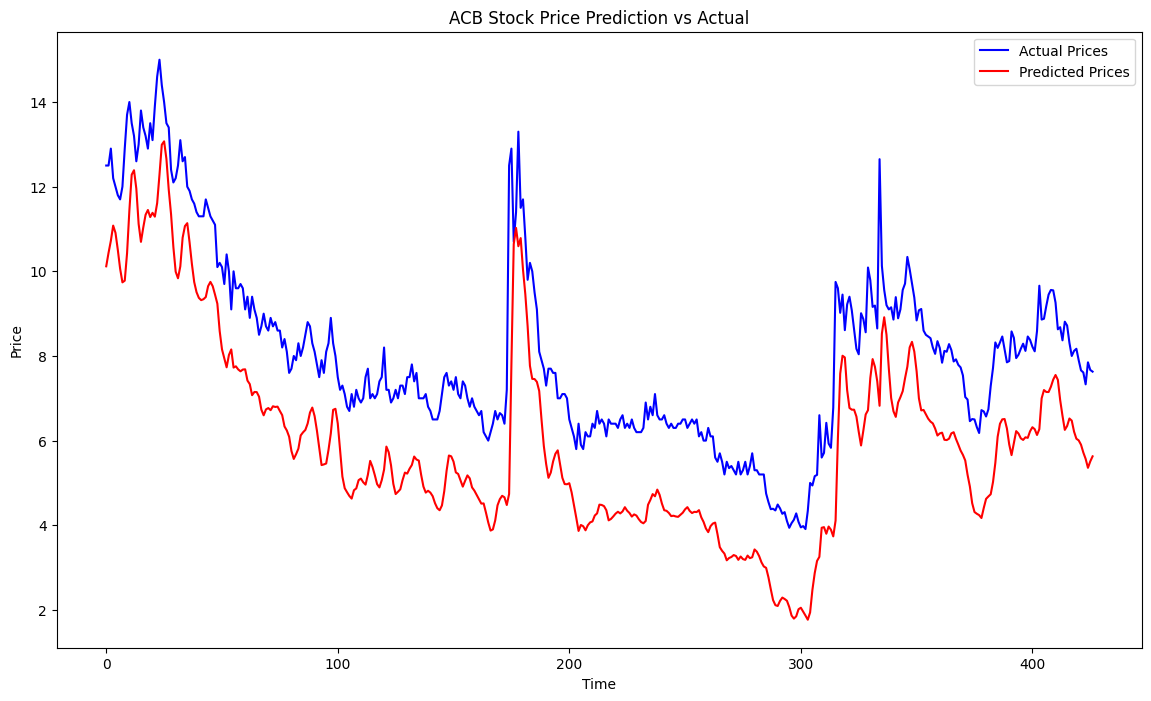

In [111]:
import matplotlib.pyplot as plt
import numpy as np

# Plot predictions vs actuals
plt.figure(figsize=(14, 8))

# Plot actual prices
plt.plot(actuals, label='Actual Prices', color='blue')

# Plot predicted prices
plt.plot(predictions, label='Predicted Prices', color='red')

# Add title and labels
plt.title('ACB Stock Price Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Price')

# Add a legend to differentiate the two lines
plt.legend()

# Display the plot
plt.show()


In [112]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# 1. Predict using the best model
predictions_scaled = best_model.predict(aapl_test_sequences)

# 2. Inverse transform the predictions and actual values (to get them back to the original scale)
# Only the 'Price' column needs to be inverse transformed, so we select the correct part of the scaler
predictions = scaler.inverse_transform(np.concatenate([predictions_scaled, np.zeros((predictions_scaled.shape[0], 2))], axis=1))[:, 0]
actuals = scaler.inverse_transform(np.concatenate([aapl_test_labels, np.zeros((aapl_test_labels.shape[0], 2))], axis=1))[:, 0]

# 3. Align the 'Date' column with the predictions
# Skip the first 60 rows in the test set as they don't have enough data for sequence generation
aligned_test_full = aapl_test_full.iloc[60:].reset_index(drop=True)
print(aligned_test_full)
# # Add predictions and actual values to the aligned test set
# aligned_test_full['Predicted Price'] = predictions
# aligned_test_full['Actual Price'] = actuals

# # Create 'Year' column by extracting year from 'Date'
# aligned_test_full['Date'] = pd.to_datetime(aligned_test_full['Date'])
# aligned_test_full['Year'] = aligned_test_full['Date'].dt.year

# # 4. Plot the predictions vs actuals by year (e.g., 2023, 2024)
# def plot_predictions_by_year(df, year):
#     plt.figure(figsize=(10, 6))
#     yearly_data = df[df['Year'] == year]
#     plt.plot(yearly_data['Date'], yearly_data['Actual Price'], label='Actual Price', color='blue')
#     plt.plot(yearly_data['Date'], yearly_data['Predicted Price'], label='Predicted Price', color='red', linestyle='--')
#     plt.title(f'Actual vs Predicted Prices in {year}')
#     plt.xlabel('Date')
#     plt.ylabel('Price')
#     plt.legend()
#     plt.show()

# # Example: Plot for 2023 and 2024
# plot_predictions_by_year(aligned_test_full, 2023)
# plot_predictions_by_year(aligned_test_full, 2024)

# # 5. Predict future values for 2025
# # Get the last sequence from 2024 data to predict 2025
# last_sequence = aapl_test_sequences[-1:]  # Last sequence in the test set
# future_predictions = []

# # Generate predictions for 2025 (let's assume 365 days into the future)
# for _ in range(365):
#     next_prediction = best_model.predict(last_sequence)
#     future_predictions.append(next_prediction[0, 0])  # Append the prediction
#     next_sequence = np.append(last_sequence[:, 1:, :], [[next_prediction[0]]], axis=1)  # Shift and append

# # Convert the future predictions to the original scale
# future_predictions = scaler.inverse_transform(np.concatenate([np.array(future_predictions).reshape(-1, 1), np.zeros((365, 2))], axis=1))[:, 0]

# # Generate future dates for 2025 (assuming daily predictions)
# start_date = aligned_test_full['Date'].max() + pd.DateOffset(1)
# future_dates = pd.date_range(start=start_date, periods=365, freq='D')

# # Create a DataFrame for 2025 predictions
# future_df = pd.DataFrame({'Date': future_dates, 'Predicted Price': future_predictions})

# # 6. Plot the predictions for 2025
# plt.figure(figsize=(10, 6))
# plt.plot(future_df['Date'], future_df['Predicted Price'], label='Predicted Price (2025)', color='green')
# plt.title('Predicted Prices for 2025')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.legend()
# plt.show()


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
        Price  MA30 Before Diff  MA90 Before Diff
0   -0.001841         -0.001665         -0.001564
1   -0.001841         -0.001822         -0.001613
2   -0.001618         -0.001937         -0.001674
3   -0.002008         -0.002061         -0.001756
4   -0.002120         -0.002186         -0.001824
..        ...               ...               ...
422 -0.004569         -0.006546         -0.008160
423 -0.004725         -0.006561         -0.008171
424 -0.004435         -0.006565         -0.008211
425 -0.004535         -0.006576         -0.008232
426 -0.004558         -0.006592         -0.008248

[427 rows x 3 columns]
